# Multiclass Support Vector Machine exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

In this exercise you will:
    
- implement a fully-vectorized **loss function** for the SVM
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** using numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [1]:
# Run some setup code for this notebook.

import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

from __future__ import print_function

# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## CIFAR-10 Data Loading and Preprocessing

In [2]:
# Load the raw CIFAR-10 data.
cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


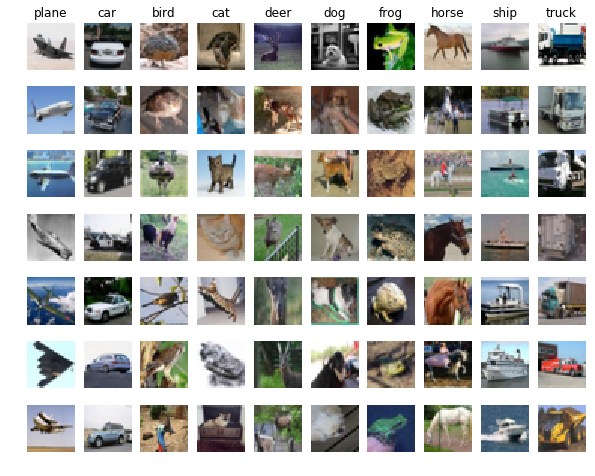

In [3]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [4]:
# Split the data into train, val, and test sets. In addition we will
# create a small development set as a subset of the training data;
# we can use this for development so our code runs faster.
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

# Our validation set will be num_validation points from the original
# training set.
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

# Our training set will be the first num_train points from the original
# training set.
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# We will also make a development set, which is a small subset of
# the training set.
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

# We use the first num_test points of the original test set as our
# test set.
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)


In [5]:
# Preprocessing: reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

# As a sanity check, print out the shapes of the data
print('Training data shape: ', X_train.shape)
print('Validation data shape: ', X_val.shape)
print('Test data shape: ', X_test.shape)
print('dev data shape: ', X_dev.shape)

Training data shape:  (49000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:  (1000, 3072)
dev data shape:  (500, 3072)


[ 130.64189796  135.98173469  132.47391837  130.05569388  135.34804082
  131.75402041  130.96055102  136.14328571  132.47636735  131.48467347]


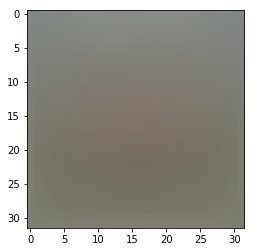

In [6]:
# Preprocessing: subtract the mean image
# first: compute the image mean based on the training data
mean_image = np.mean(X_train, axis=0)
print(mean_image[:10]) # print a few of the elements
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # visualize the mean image
plt.show()

In [7]:
# second: subtract the mean image from train and test data
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image

In [8]:
# third: append the bias dimension of ones (i.e. bias trick) so that our SVM
# only has to worry about optimizing a single weight matrix W.
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)

(49000, 3073) (1000, 3073) (1000, 3073) (500, 3073)


## SVM Classifier

Your code for this section will all be written inside **cs231n/classifiers/linear_svm.py**. 

As you can see, we have prefilled the function `compute_loss_naive` which uses for loops to evaluate the multiclass SVM loss function. 

In [9]:
# Evaluate the naive implementation of the loss we provided for you:
from cs231n.classifiers.linear_svm import svm_loss_naive
import time

# generate a random SVM weight matrix of small numbers
W = np.random.randn(3073, 10) * 0.0001 

loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.000005)
print('loss: %f' % (loss, ))

loss: 9.259995


The `grad` returned from the function above is right now all zero. Derive and implement the gradient for the SVM cost function and implement it inline inside the function `svm_loss_naive`. You will find it helpful to interleave your new code inside the existing function.

To check that you have correctly implemented the gradient correctly, you can numerically estimate the gradient of the loss function and compare the numeric estimate to the gradient that you computed. We have provided code that does this for you:

In [10]:
# Once you've implemented the gradient, recompute it with the code below
# and gradient check it with the function we provided for you

# Compute the loss and its gradient at W.
loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.0)

# Numerically compute the gradient along several randomly chosen dimensions, and
# compare them with your analytically computed gradient. The numbers should match
# almost exactly along all dimensions.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad)

# do the gradient check once again with regularization turned on
# you didn't forget the regularization gradient did you?
loss, grad = svm_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad)

numerical: -6.450859 analytic: -6.512398, relative error: 4.747146e-03
numerical: 16.647152 analytic: 16.647152, relative error: 1.984909e-11
numerical: -5.740262 analytic: -5.673009, relative error: 5.892541e-03
numerical: 8.299380 analytic: 8.299380, relative error: 8.653109e-12
numerical: -29.357762 analytic: -29.357762, relative error: 7.534844e-12
numerical: -19.400796 analytic: -19.467823, relative error: 1.724452e-03
numerical: -3.037560 analytic: -3.037560, relative error: 6.987042e-11
numerical: -14.312511 analytic: -14.312511, relative error: 6.219261e-12
numerical: 13.562641 analytic: 13.562641, relative error: 1.205670e-11
numerical: -18.234572 analytic: -18.160422, relative error: 2.037356e-03
numerical: 5.430799 analytic: 5.438656, relative error: 7.228300e-04
numerical: 18.784435 analytic: 18.774220, relative error: 2.719747e-04
numerical: -6.167020 analytic: -6.222158, relative error: 4.450503e-03
numerical: 9.593318 analytic: 9.590916, relative error: 1.252054e-04
nume

### Inline Question 1:
It is possible that once in a while a dimension in the gradcheck will not match exactly. What could such a discrepancy be caused by? Is it a reason for concern? What is a simple example in one dimension where a gradient check could fail? *Hint: the SVM loss function is not strictly speaking differentiable*

**Your Answer:** *Gradcheck not match exactly when we have zeros dimension, so grad is almost zero for numerical.*

In [11]:
# Next implement the function svm_loss_vectorized; for now only compute the loss;
# we will implement the gradient in a moment.
tic = time.time()
loss_naive, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.linear_svm import svm_loss_vectorized
tic = time.time()
loss_vectorized, _ = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# The losses should match but your vectorized implementation should be much faster.
print('difference: %f' % (loss_naive - loss_vectorized))

Naive loss: 9.259995e+00 computed in 0.166743s
Vectorized loss: 9.259995e+00 computed in 0.010154s
difference: -0.000000


In [12]:
# Complete the implementation of svm_loss_vectorized, and compute the gradient
# of the loss function in a vectorized way.

# The naive implementation and the vectorized implementation should match, but
# the vectorized version should still be much faster.
tic = time.time()
_, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss and gradient: computed in %fs' % (toc - tic))

tic = time.time()
_, grad_vectorized = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss and gradient: computed in %fs' % (toc - tic))

# The loss is a single number, so it is easy to compare the values computed
# by the two implementations. The gradient on the other hand is a matrix, so
# we use the Frobenius norm to compare them.
difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('difference: %f' % difference)

Naive loss and gradient: computed in 0.158944s
Vectorized loss and gradient: computed in 0.004003s
difference: 0.000000


### Stochastic Gradient Descent

We now have vectorized and efficient expressions for the loss, the gradient and our gradient matches the numerical gradient. We are therefore ready to do SGD to minimize the loss.

In [13]:
# In the file linear_classifier.py, implement SGD in the function
# LinearClassifier.train() and then run it with the code below.
from cs231n.classifiers import LinearSVM
svm = LinearSVM()
tic = time.time()
loss_hist = svm.train(X_train, y_train, learning_rate=1e-7, reg=2.5e4,
                      num_iters=1500, verbose=True)
toc = time.time()
print('That took %fs' % (toc - tic))

iteration 0 / 1500: loss 792.093731
iteration 100 / 1500: loss 472.075922
iteration 200 / 1500: loss 288.075550
iteration 300 / 1500: loss 175.128626
iteration 400 / 1500: loss 107.157216
iteration 500 / 1500: loss 66.619099
iteration 600 / 1500: loss 42.486746
iteration 700 / 1500: loss 27.742235
iteration 800 / 1500: loss 18.149468
iteration 900 / 1500: loss 13.927657
iteration 1000 / 1500: loss 10.174145
iteration 1100 / 1500: loss 8.094964
iteration 1200 / 1500: loss 6.644513
iteration 1300 / 1500: loss 6.440623
iteration 1400 / 1500: loss 5.801509
That took 6.427590s


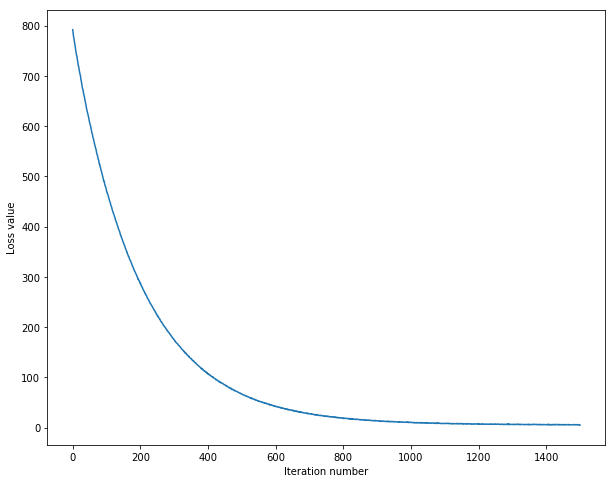

In [14]:
# A useful debugging strategy is to plot the loss as a function of
# iteration number:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [15]:
# Write the LinearSVM.predict function and evaluate the performance on both the
# training and validation set
y_train_pred = svm.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = svm.predict(X_val)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

training accuracy: 0.383469
validation accuracy: 0.387000


In [16]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of about 0.4 on the validation set.
# learning_ratest = np
import itertools as it

learning_rates = np.logspace(-9, -5, num=9)
regularization_strengths = np.logspace(2, 6, num=13)
combs = it.product(learning_rates, regularization_strengths)
# results is dictionary mapping tuples of the form
# (learning_rate, regularization_strength) to tuples of the form
# (training_accuracy, validation_accuracy). The accuracy is simply the fraction
# of data points that are correctly classified.
results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best_svm = None # The LinearSVM object that achieved the highest validation rate.

################################################################################
# TODO:                                                                        #
# Write code that chooses the best hyperparameters by tuning on the validation #
# set. For each combination of hyperparameters, train a linear SVM on the      #
# training set, compute its accuracy on the training and validation sets, and  #
# store these numbers in the results dictionary. In addition, store the best   #
# validation accuracy in best_val and the LinearSVM object that achieves this  #
# accuracy in best_svm.                                                        #
#                                                                              #
# Hint: You should use a small value for num_iters as you develop your         #
# validation code so that the SVMs don't take much time to train; once you are #
# confident that your validation code works, you should rerun the validation   #
# code with a larger value for num_iters.                                      #
################################################################################
# pass
for lr, reg in combs:
    print(lr, reg)
    svm = LinearSVM()
    loss_hist = svm.train(X_train, y_train, learning_rate=lr, reg=reg,
                          num_iters=1500, verbose=True)
    y_train_pred = svm.predict(X_train)
    y_val_pred = svm.predict(X_val)
    
    train_acc = np.mean(y_train == y_train_pred)
    val_acc = (np.mean(y_val == y_val_pred))

    results[(lr, reg)] = (train_acc, val_acc)
    if best_val < val_acc:
        best_val = val_acc
        best_svm = svm
        best_lr = lr
        best_reg = reg

################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

1e-09 100.0
iteration 0 / 1500: loss 29.502628
iteration 100 / 1500: loss 24.287955
iteration 200 / 1500: loss 26.445465
iteration 300 / 1500: loss 26.342468
iteration 400 / 1500: loss 25.281697
iteration 500 / 1500: loss 22.650353
iteration 600 / 1500: loss 26.003664
iteration 700 / 1500: loss 22.358644
iteration 800 / 1500: loss 20.572611
iteration 900 / 1500: loss 21.808097
iteration 1000 / 1500: loss 20.906981
iteration 1100 / 1500: loss 19.490280
iteration 1200 / 1500: loss 22.119719
iteration 1300 / 1500: loss 20.395294
iteration 1400 / 1500: loss 20.105528
1e-09 215.443469003
iteration 0 / 1500: loss 31.626847
iteration 100 / 1500: loss 29.282296
iteration 200 / 1500: loss 32.130151
iteration 300 / 1500: loss 24.022829
iteration 400 / 1500: loss 25.104212
iteration 500 / 1500: loss 27.451540
iteration 600 / 1500: loss 24.828150
iteration 700 / 1500: loss 25.780688
iteration 800 / 1500: loss 23.231706
iteration 900 / 1500: loss 22.603383
iteration 1000 / 1500: loss 24.633051
iter

iteration 1300 / 1500: loss 15.532193
iteration 1400 / 1500: loss 16.518577
3.16227766017e-09 215.443469003
iteration 0 / 1500: loss 30.981754
iteration 100 / 1500: loss 26.928252
iteration 200 / 1500: loss 26.781784
iteration 300 / 1500: loss 22.452125
iteration 400 / 1500: loss 22.218126
iteration 500 / 1500: loss 22.431280
iteration 600 / 1500: loss 21.762151
iteration 700 / 1500: loss 21.973050
iteration 800 / 1500: loss 21.259170
iteration 900 / 1500: loss 22.161118
iteration 1000 / 1500: loss 19.604788
iteration 1100 / 1500: loss 22.104751
iteration 1200 / 1500: loss 19.342956
iteration 1300 / 1500: loss 20.529123
iteration 1400 / 1500: loss 19.624082
3.16227766017e-09 464.158883361
iteration 0 / 1500: loss 37.855144
iteration 100 / 1500: loss 33.254427
iteration 200 / 1500: loss 33.532709
iteration 300 / 1500: loss 33.380633
iteration 400 / 1500: loss 32.603525
iteration 500 / 1500: loss 31.198248
iteration 600 / 1500: loss 31.121774
iteration 700 / 1500: loss 29.446225
iteratio

iteration 800 / 1500: loss 15.787602
iteration 900 / 1500: loss 16.610919
iteration 1000 / 1500: loss 17.366515
iteration 1100 / 1500: loss 17.207105
iteration 1200 / 1500: loss 15.644883
iteration 1300 / 1500: loss 16.475233
iteration 1400 / 1500: loss 16.202648
1e-08 464.158883361
iteration 0 / 1500: loss 32.703707
iteration 100 / 1500: loss 30.087696
iteration 200 / 1500: loss 28.626473
iteration 300 / 1500: loss 27.574849
iteration 400 / 1500: loss 25.847972
iteration 500 / 1500: loss 26.936208
iteration 600 / 1500: loss 26.448778
iteration 700 / 1500: loss 26.423588
iteration 800 / 1500: loss 24.883361
iteration 900 / 1500: loss 23.776859
iteration 1000 / 1500: loss 25.306943
iteration 1100 / 1500: loss 25.529392
iteration 1200 / 1500: loss 23.210503
iteration 1300 / 1500: loss 23.115564
iteration 1400 / 1500: loss 23.833234
1e-08 1000.0
iteration 0 / 1500: loss 54.492147
iteration 100 / 1500: loss 47.315507
iteration 200 / 1500: loss 49.887520
iteration 300 / 1500: loss 44.227656

iteration 800 / 1500: loss 24.965342
iteration 900 / 1500: loss 22.617543
iteration 1000 / 1500: loss 20.652512
iteration 1100 / 1500: loss 22.269507
iteration 1200 / 1500: loss 22.069836
iteration 1300 / 1500: loss 21.462446
iteration 1400 / 1500: loss 21.611006
3.16227766017e-08 1000.0
iteration 0 / 1500: loss 51.343474
iteration 100 / 1500: loss 44.637327
iteration 200 / 1500: loss 40.870661
iteration 300 / 1500: loss 40.766286
iteration 400 / 1500: loss 40.264750
iteration 500 / 1500: loss 40.660547
iteration 600 / 1500: loss 38.459431
iteration 700 / 1500: loss 38.618125
iteration 800 / 1500: loss 38.807773
iteration 900 / 1500: loss 36.684626
iteration 1000 / 1500: loss 39.048789
iteration 1100 / 1500: loss 35.610594
iteration 1200 / 1500: loss 36.154790
iteration 1300 / 1500: loss 34.214615
iteration 1400 / 1500: loss 35.664770
3.16227766017e-08 2154.43469003
iteration 0 / 1500: loss 91.452291
iteration 100 / 1500: loss 77.960319
iteration 200 / 1500: loss 73.829522
iteration 30

iteration 800 / 1500: loss 33.257414
iteration 900 / 1500: loss 31.813174
iteration 1000 / 1500: loss 31.609283
iteration 1100 / 1500: loss 30.437638
iteration 1200 / 1500: loss 29.894403
iteration 1300 / 1500: loss 28.501203
iteration 1400 / 1500: loss 28.058459
1e-07 2154.43469003
iteration 0 / 1500: loss 85.534533
iteration 100 / 1500: loss 73.752315
iteration 200 / 1500: loss 68.855946
iteration 300 / 1500: loss 66.273689
iteration 400 / 1500: loss 63.004127
iteration 500 / 1500: loss 59.623932
iteration 600 / 1500: loss 57.388707
iteration 700 / 1500: loss 54.647582
iteration 800 / 1500: loss 52.039163
iteration 900 / 1500: loss 50.842605
iteration 1000 / 1500: loss 47.197699
iteration 1100 / 1500: loss 45.849692
iteration 1200 / 1500: loss 43.329263
iteration 1300 / 1500: loss 42.972626
iteration 1400 / 1500: loss 39.689061
1e-07 4641.58883361
iteration 0 / 1500: loss 164.795514
iteration 100 / 1500: loss 140.609038
iteration 200 / 1500: loss 126.413966
iteration 300 / 1500: loss

iteration 1200 / 1500: loss 16.436804
iteration 1300 / 1500: loss 14.606350
iteration 1400 / 1500: loss 13.231293
3.16227766017e-07 4641.58883361
iteration 0 / 1500: loss 164.719076
iteration 100 / 1500: loss 111.515290
iteration 200 / 1500: loss 83.780424
iteration 300 / 1500: loss 63.059585
iteration 400 / 1500: loss 47.776043
iteration 500 / 1500: loss 36.480969
iteration 600 / 1500: loss 27.863896
iteration 700 / 1500: loss 22.423867
iteration 800 / 1500: loss 16.641075
iteration 900 / 1500: loss 13.483805
iteration 1000 / 1500: loss 11.525080
iteration 1100 / 1500: loss 10.474833
iteration 1200 / 1500: loss 8.900543
iteration 1300 / 1500: loss 7.531369
iteration 1400 / 1500: loss 6.908504
3.16227766017e-07 10000.0
iteration 0 / 1500: loss 332.993779
iteration 100 / 1500: loss 166.911511
iteration 200 / 1500: loss 88.354010
iteration 300 / 1500: loss 49.492558
iteration 400 / 1500: loss 28.413287
iteration 500 / 1500: loss 17.482230
iteration 600 / 1500: loss 12.081895
iteration 70

iteration 100 / 1500: loss 46.168981
iteration 200 / 1500: loss 12.220687
iteration 300 / 1500: loss 7.092810
iteration 400 / 1500: loss 5.185151
iteration 500 / 1500: loss 6.912357
iteration 600 / 1500: loss 6.595989
iteration 700 / 1500: loss 6.479345
iteration 800 / 1500: loss 6.816362
iteration 900 / 1500: loss 5.362503
iteration 1000 / 1500: loss 5.631291
iteration 1100 / 1500: loss 6.741232
iteration 1200 / 1500: loss 6.628788
iteration 1300 / 1500: loss 6.521133
iteration 1400 / 1500: loss 5.586869
1e-06 21544.3469003
iteration 0 / 1500: loss 679.468101
iteration 100 / 1500: loss 14.626506
iteration 200 / 1500: loss 6.963406
iteration 300 / 1500: loss 7.241068
iteration 400 / 1500: loss 5.886028
iteration 500 / 1500: loss 6.606213
iteration 600 / 1500: loss 8.266652
iteration 700 / 1500: loss 5.970195
iteration 800 / 1500: loss 7.291884
iteration 900 / 1500: loss 6.198705
iteration 1000 / 1500: loss 6.237812
iteration 1100 / 1500: loss 6.734887
iteration 1200 / 1500: loss 6.4498

iteration 500 / 1500: loss 14.286024
iteration 600 / 1500: loss 11.515102
iteration 700 / 1500: loss 13.694084
iteration 800 / 1500: loss 16.650455
iteration 900 / 1500: loss 13.128176
iteration 1000 / 1500: loss 20.379649
iteration 1100 / 1500: loss 10.049826
iteration 1200 / 1500: loss 17.873368
iteration 1300 / 1500: loss 15.623430
iteration 1400 / 1500: loss 10.737249
3.16227766017e-06 46415.8883361
iteration 0 / 1500: loss 1453.578530
iteration 100 / 1500: loss 16.616808
iteration 200 / 1500: loss 14.451215
iteration 300 / 1500: loss 22.281570
iteration 400 / 1500: loss 18.212224
iteration 500 / 1500: loss 12.372109
iteration 600 / 1500: loss 16.744488
iteration 700 / 1500: loss 24.892503
iteration 800 / 1500: loss 17.728562
iteration 900 / 1500: loss 12.434055
iteration 1000 / 1500: loss 15.646133
iteration 1100 / 1500: loss 17.882163
iteration 1200 / 1500: loss 16.695405
iteration 1300 / 1500: loss 20.028903
iteration 1400 / 1500: loss 16.875186
3.16227766017e-06 100000.0
iterat

cs231n/classifiers/linear_svm.py:111: RuntimeWarning: overflow encountered in double_scalars
  loss += reg * np.sum(W * W)
cs231n/classifiers/linear_svm.py:111: RuntimeWarning: overflow encountered in multiply
  loss += reg * np.sum(W * W)


iteration 500 / 1500: loss inf
iteration 600 / 1500: loss inf
iteration 700 / 1500: loss inf
iteration 800 / 1500: loss inf
iteration 900 / 1500: loss inf


cs231n/classifiers/linear_svm.py:112: RuntimeWarning: overflow encountered in multiply
  dW += reg * W
cs231n/classifiers/linear_svm.py:84: RuntimeWarning: invalid value encountered in subtract
  margins = np.maximum(0, scores - correct_class_score[:, None] + 1)
cs231n/classifiers/linear_svm.py:98: RuntimeWarning: invalid value encountered in greater
  mask = np.where(margins > 0, True, False)
cs231n/classifiers/linear_classifier.py:70: RuntimeWarning: invalid value encountered in subtract
  self.W -= learning_rate * grad


iteration 1000 / 1500: loss nan
iteration 1100 / 1500: loss nan
iteration 1200 / 1500: loss nan
iteration 1300 / 1500: loss nan
iteration 1400 / 1500: loss nan
1e-05 100.0
iteration 0 / 1500: loss 26.446763
iteration 100 / 1500: loss 18.191215
iteration 200 / 1500: loss 21.088856
iteration 300 / 1500: loss 20.006297
iteration 400 / 1500: loss 25.901662
iteration 500 / 1500: loss 23.952535
iteration 600 / 1500: loss 26.177578
iteration 700 / 1500: loss 26.186314
iteration 800 / 1500: loss 25.907239
iteration 900 / 1500: loss 23.324808
iteration 1000 / 1500: loss 21.831128
iteration 1100 / 1500: loss 23.619719
iteration 1200 / 1500: loss 19.249716
iteration 1300 / 1500: loss 32.784493
iteration 1400 / 1500: loss 19.674043
1e-05 215.443469003
iteration 0 / 1500: loss 30.791204
iteration 100 / 1500: loss 20.528532
iteration 200 / 1500: loss 28.707249
iteration 300 / 1500: loss 17.553180
iteration 400 / 1500: loss 18.739486
iteration 500 / 1500: loss 24.847789
iteration 600 / 1500: loss 20.

iteration 300 / 1500: loss inf
iteration 400 / 1500: loss inf
iteration 500 / 1500: loss inf
iteration 600 / 1500: loss nan
iteration 700 / 1500: loss nan
iteration 800 / 1500: loss nan
iteration 900 / 1500: loss nan
iteration 1000 / 1500: loss nan
iteration 1100 / 1500: loss nan
iteration 1200 / 1500: loss nan
iteration 1300 / 1500: loss nan
iteration 1400 / 1500: loss nan
1e-05 1000000.0
iteration 0 / 1500: loss 30585.773530
iteration 100 / 1500: loss 2160052064137424367887492012422159335542118431961408049255289028053368521605852936812420647062081287099724324215712475009017951519560400323104972081931722556813223649919011629045403461404793503744.000000
iteration 200 / 1500: loss inf
iteration 300 / 1500: loss inf
iteration 400 / 1500: loss nan
iteration 500 / 1500: loss nan
iteration 600 / 1500: loss nan
iteration 700 / 1500: loss nan
iteration 800 / 1500: loss nan
iteration 900 / 1500: loss nan
iteration 1000 / 1500: loss nan
iteration 1100 / 1500: loss nan
iteration 1200 / 1500: los

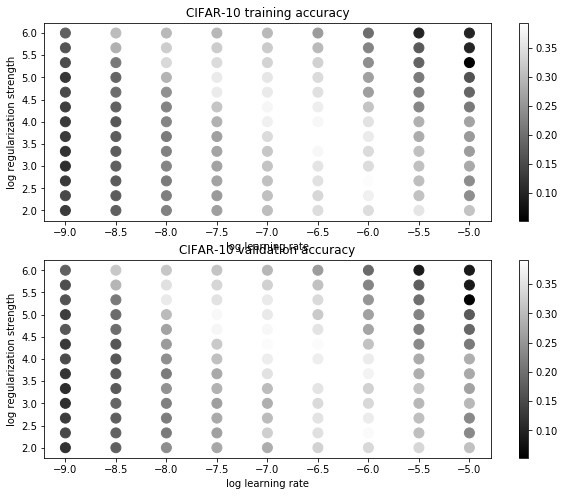

In [17]:
# Visualize the cross-validation results
import math
x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')

# plot validation accuracy
colors = [results[x][1] for x in results] # default size of markers is 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.show()

In [18]:
# Evaluate the best svm on test set
y_test_pred = best_svm.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('linear SVM on raw pixels final test set accuracy: %f' % test_accuracy)

linear SVM on raw pixels final test set accuracy: 0.357000


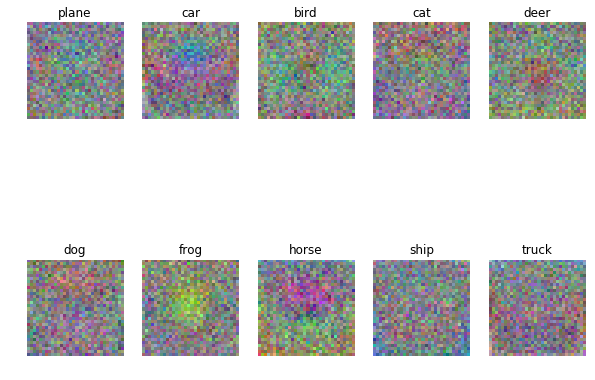

In [19]:
# Visualize the learned weights for each class.
# Depending on your choice of learning rate and regularization strength, these may
# or may not be nice to look at.
w = best_svm.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)
w_min, w_max = np.min(w), np.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
      
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])

### Inline question 2:
Describe what your visualized SVM weights look like, and offer a brief explanation for why they look they way that they do.

**Your answer:** *
- plane - there are empty space in center
- car - red probably because most cars in datasets are red
- bird - brown in center
- cat - hard to recognize
- deer - some brown in the center
- dog - brown in center, bigger the for deer
- frog - green/yellow in the center
- horse -  brown with two heads
- ship - hard to recognize
- truck - some brown with mirror
*